# Imports

## Import gen

In [1]:
import pandas as pd
import os,sys
import pickle
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt
from IPython.display import clear_output

2022-06-16 11:39:23.658394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.config.list_physical_devices()

2022-06-16 11:39:26.842865: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-16 11:39:26.844373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-16 11:39:26.896320: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.785GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2022-06-16 11:39:26.896376: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-16 11:39:26.900293: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-16 11:39:26.900434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.1

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Import Sklearn

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.datasets import fetch_openml

## Import Keras

In [5]:
from keras.utils.vis_utils import plot_model

In [35]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten

## Import datasets

Read from file or if file do not exist get from openml

In [7]:
path_to_file = '../data/digit_dataset.pkl'

In [8]:
if os.path.exists(path_to_file):
    print('Getting data set from local')
    with open(path_to_file, 'rb') as f:
        minst = pickle.load(f)
else:
    print('Getting data set from openML')
    minst = fetch_openml('mnist_784')
    with open(path_to_file, 'wb') as f:
        pickle.dump(minst, f)

Getting data set from local


In [9]:
minst.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
X,y = minst['data'],minst['target']

## Encode y for multilabel

In [11]:
onehot = OneHotEncoder(sparse=False)
y_encoded = onehot.fit_transform(y.values.reshape(-1,1))

# Split train test

In [12]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y_encoded[:60000],y_encoded[60000:]

# Standardisation 

In [13]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualisation des chiffres

In [14]:
def show_image(dataset,indice):
    values = dataset[indice]
    img = values.reshape(28,28)
    plt.imshow(img,cmap='binary')
    plt.axis('off')
    plt.show()

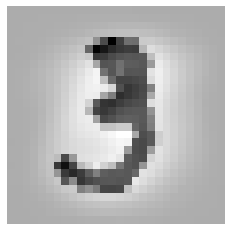

In [15]:
show_image(X_train,10)

# Test model neuronal 'simple' 

- input => 784  
- 2 hidden layers of 10-20 neurons
- 1 output layer of with 10 neurons => one by class 

In [16]:
simple_model = Sequential(
    [
        Dense(16,activation='relu'),
        Dense(14,activation='relu'),
        Dense(10,activation='softmax',name='output_layer'),
    ]
)

2022-06-16 11:39:29.389619: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 11:39:29.390215: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-16 11:39:29.390710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.785GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2022-06-16 11:39:29.390759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-16 11:39:29.390796: I tensorflow/stream_executor/plat

In [17]:
simple_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = simple_model.fit(X_train,y_train,epochs=10,batch_size=124,verbose=1,validation_split=0.1)

2022-06-16 11:39:30.717181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-16 11:39:30.734593: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1700000000 Hz


Epoch 1/10


2022-06-16 11:39:31.308438: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


436/436 [==============================] - 3s 4ms/step - loss: 0.3976 - accuracy: 0.4087 - val_loss: 0.0607 - val_accuracy: 0.9195
Epoch 2/10
436/436 [==============================] - 1s 3ms/step - loss: 0.0636 - accuracy: 0.9077 - val_loss: 0.0429 - val_accuracy: 0.9392
Epoch 3/10
436/436 [==============================] - 1s 3ms/step - loss: 0.0467 - accuracy: 0.9322 - val_loss: 0.0375 - val_accuracy: 0.9467
Epoch 4/10
436/436 [==============================] - 1s 3ms/step - loss: 0.0416 - accuracy: 0.9394 - val_loss: 0.0352 - val_accuracy: 0.9497
Epoch 5/10
436/436 [==============================] - 1s 3ms/step - loss: 0.0374 - accuracy: 0.9443 - val_loss: 0.0340 - val_accuracy: 0.9520
Epoch 6/10
436/436 [==============================] - 1s 3ms/step - loss: 0.0345 - accuracy: 0.9492 - val_loss: 0.0330 - val_accuracy: 0.9542
Epoch 7/10
436/436 [==============================] - 1s 3ms/step - loss: 0.0324 - accuracy: 0.9519 - val_loss: 0.0321 - val_accuracy: 0.9557
Epoch 8/10
436/43

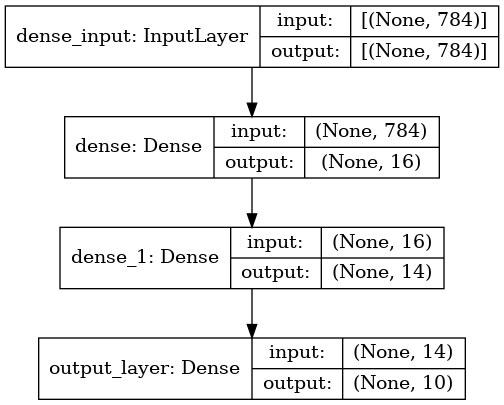

In [19]:
plot_model(simple_model, to_file='../img/digits/simple_model.png', show_shapes=True)

In [20]:
y_pred = simple_model.predict(X_test)

In [21]:
_, test_acc = simple_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0353 - accuracy: 0.9486


# CNN

## data

In [32]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y_encoded[:60000],y_encoded[60000:]

## reshape to use the data as img

In [43]:
X_train_img = X_train.values.reshape(len(X_train),28,28,1)/255
X_test_img = X_test.values.reshape(len(X_test),28,28,1)/255

In [44]:
X_train_img.shape

(60000, 28, 28, 1)

## Model

In [45]:
simple_cnn = Sequential(
    [
        Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28, 1)),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(10,activation='softmax',name='outputlayer'),
    ]
)

In [46]:
simple_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
simple_cnn.fit(X_train_img, y_train, epochs=10,batch_size=50, validation_split=0.1)

Epoch 1/10


2022-06-16 11:47:55.821761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-16 11:47:57.452388: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-16 11:47:57.565973: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1080/1080 [==============================] - 8s 4ms/step - loss: 0.4978 - accuracy: 0.8608 - val_loss: 0.1186 - val_accuracy: 0.9680
Epoch 2/10
1080/1080 [==============================] - 4s 3ms/step - loss: 0.1218 - accuracy: 0.9668 - val_loss: 0.0825 - val_accuracy: 0.9783
Epoch 3/10
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0842 - accuracy: 0.9760 - val_loss: 0.0659 - val_accuracy: 0.9832
Epoch 4/10
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0676 - accuracy: 0.9811 - val_loss: 0.0675 - val_accuracy: 0.9810
Epoch 5/10
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0575 - accuracy: 0.9837 - val_loss: 0.0609 - val_accuracy: 0.9830
Epoch 6/10
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0489 - accuracy: 0.9854 - val_loss: 0.0621 - val_accuracy: 0.9843
Epoch 7/10
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0440 - accuracy: 0.9862 - val_loss: 0.0614 - val_accuracy: 0.9823
Epo

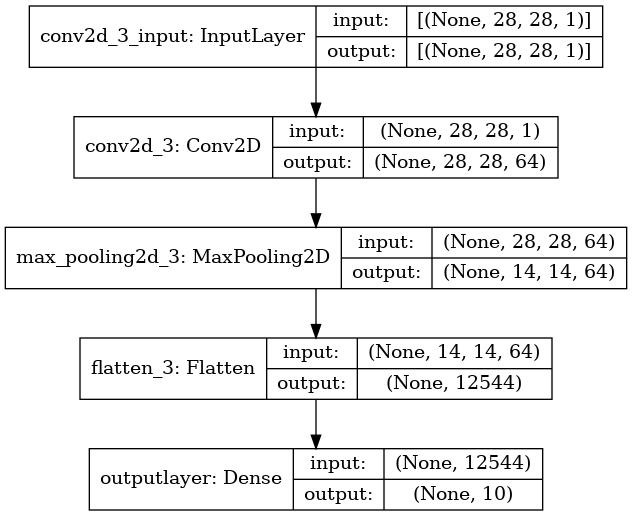

In [48]:
plot_model(simple_cnn, to_file='../img/digits/simple_cnn_model.png', show_shapes=True)

In [49]:
_, test_acc = simple_cnn.evaluate(X_test_img, y_test)
print(test_acc)

313/313 [==============================] - 3s 6ms/step - loss: 0.0678 - accuracy: 0.9796
0.9796000123023987
